In [5]:
import pandas as pd

def read_excel_sheet(file_path, sheet_name=None, header=0):
    """
    Reads a specific sheet from an Excel file and returns a DataFrame.
    
    Args:
    file_path (str): Path to the Excel file.
    sheet_name (str or int, optional): Name or index of the sheet to read. If None, reads the first sheet.
    header_row (int, optional): Row number to use as the header (0-indexed). 
                                If None, assumes the first row is the header.
    
    Returns:
    pandas.DataFrame: DataFrame containing the sheet data.
    """
    # If header_row is None, pandas will automatically use the first row as header
    df = pd.read_excel(file_path, sheet_name=sheet_name, header=header)

    return df

In [8]:
path = '../shared_data_read_only/Data/AfriKids/ExternalReports/GES_EMIS/Census Data.xlsx'

In [34]:
import pandas as pd

def group_and_sum_by_region(df, columns_to_sum):
    # Ensure all specified columns exist in the DataFrame
    existing_columns = [col for col in columns_to_sum if col in df.columns and col != 'Year']
    if not existing_columns:
        raise ValueError("None of the specified numeric columns exist in the DataFrame")
    
    # Convert columns to numeric, ignoring errors
    for col in existing_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Group by Region and Year, and calculate the mean of the specified columns
    grouped_df = df.groupby(['Region', 'Year'])[existing_columns].mean().reset_index()
    
    # Sort the DataFrame by Region and Year
    grouped_df = grouped_df.sort_values(['Region', 'Year'])
    
    return grouped_df

def read_multiple_sheets(file_path, sheet_names, columns_to_sum):
    all_data = []
    
    for sheet_name in sheet_names:
        # Read the sheet
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        
        # Standardize column names
        if 'region' in df.columns:
            df = df.rename(columns={'region': 'Region'})
        if 'PreS_TotSchs' in df.columns:
            df = df.rename(columns={'PreS_TotSchs': 'PreSch_TotSchs'})
        
        df = df.rename(columns={'PreSch_TotSchs': 'number_of_pre_school'})
        df = df.rename(columns={'Kg_TotSchs': 'number_of_kg_school'})
        df = df.rename(columns={'Prm_TotSchs': 'number_of_primary_school'})
        df = df.rename(columns={'JHS_TotSchs': 'number_of_jhs_school'})
        df = df.rename(columns={'SHS_TotSchs': 'number_of_shs_school'})
        
        
        
        # Extract year from sheet name
        year = sheet_name.split('_')[-2] + '_' + sheet_name.split('_')[-1]
        print(f"Processing data for year: {year}")
        
        # Add year column
        df['Year'] = year
        
        # Append to list
        all_data.append(df)
    
    # Combine all DataFrames
    combined_df = pd.concat(all_data, ignore_index=True)
    
    # Now apply grouping and summing to the combined data
    grouped_df = group_and_sum_by_region(combined_df, columns_to_sum + ['Year'])
    
    return grouped_df

# Example usage
sheet_names = ['No_of_Schools_2016_2017', 'No_of_Schools_2017_2018', 'No_of_Schools_2018_2019']
columns_to_sum = ['number_of_pre_school', 'number_of_kg_school', 'number_of_primary_school', 'number_of_jhs_school', 'number_of_shs_school']  # Add other numeric columns as needed

schools_data = read_multiple_sheets(path, sheet_names, columns_to_sum)

# Display the first few rows of the combined data
print(combined_data.head(15))  # Showing first 15 rows to see data from different years

Processing data for year: 2016_2017
Processing data for year: 2017_2018
Processing data for year: 2018_2019
           Region       Year  Pop_0_5_Total  Pop_6_11_Total  Pop_12_14_Total  \
0         ASHANTI  2016_2017      1176969.0        987933.0         603533.0   
1     BRONG AHAFO  2016_2017       620344.0        525214.0         313475.0   
2         CENTRAL  2016_2017       547719.0        482399.0         281052.0   
3         EASTERN  2016_2017       670933.0        561087.0         343518.0   
4   GREATER ACCRA  2016_2017       858747.0        672367.0         408278.0   
5        NORTHERN  2016_2017       800462.0        614772.0         314599.0   
6      UPPER EAST  2016_2017       279216.0        249939.0         144659.0   
7      UPPER WEST  2016_2017       187045.0        167266.0          96359.0   
8           VOLTA  2016_2017       553358.0        446354.0         264998.0   
9         WESTERN  2016_2017       658883.0        542109.0         322115.0   
10        AS

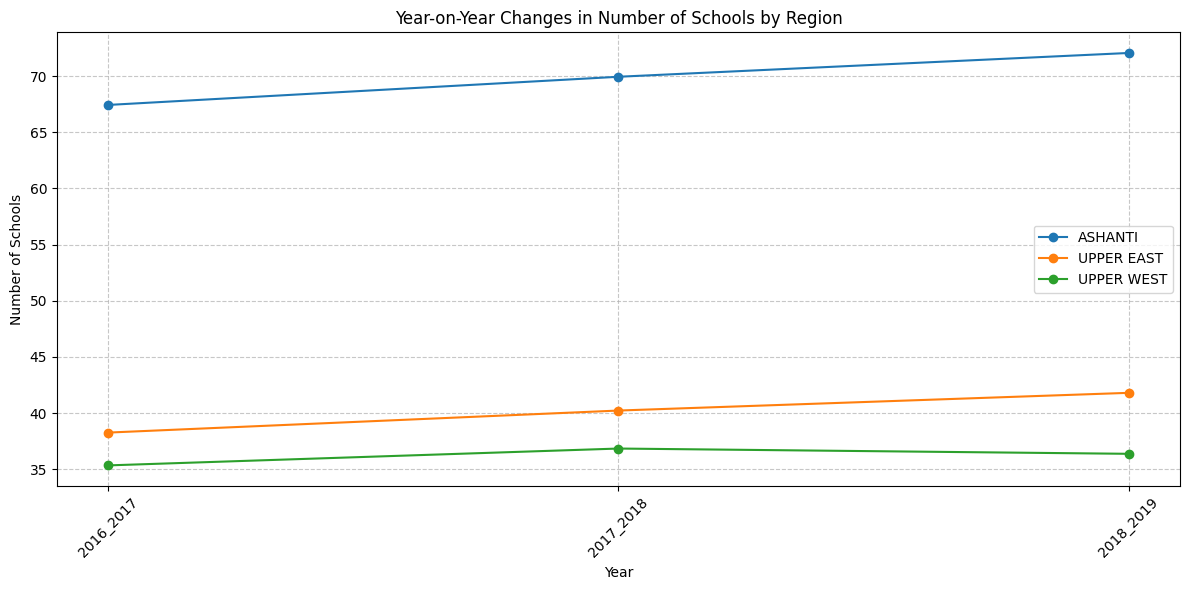

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_school_trends(df, regions_to_plot):
    # Filter the DataFrame for the specified regions
    df_filtered = df[df['Region'].isin(regions_to_plot)]
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    
    for region in regions_to_plot:
        region_data = df_filtered[df_filtered['Region'] == region]
        plt.plot(region_data['Year'], region_data['number_of_kg_school'], marker='o', label=region)
    
    plt.title('Year-on-Year Changes in Number of Schools by Region')
    plt.xlabel('Year')
    plt.ylabel('Number of Schools')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Adjust layout to prevent cutting off labels
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Assuming 'combined_data' is your DataFrame from the previous step
# If it's not, you'll need to load your data here

# Specify the regions you want to plot
regions_to_plot = ['ASHANTI', 'UPPER EAST', 'UPPER WEST']

# Call the function to create the plot
plot_school_trends(combined_data, regions_to_plot)

Using data from 2016_2017 to 2018_2019


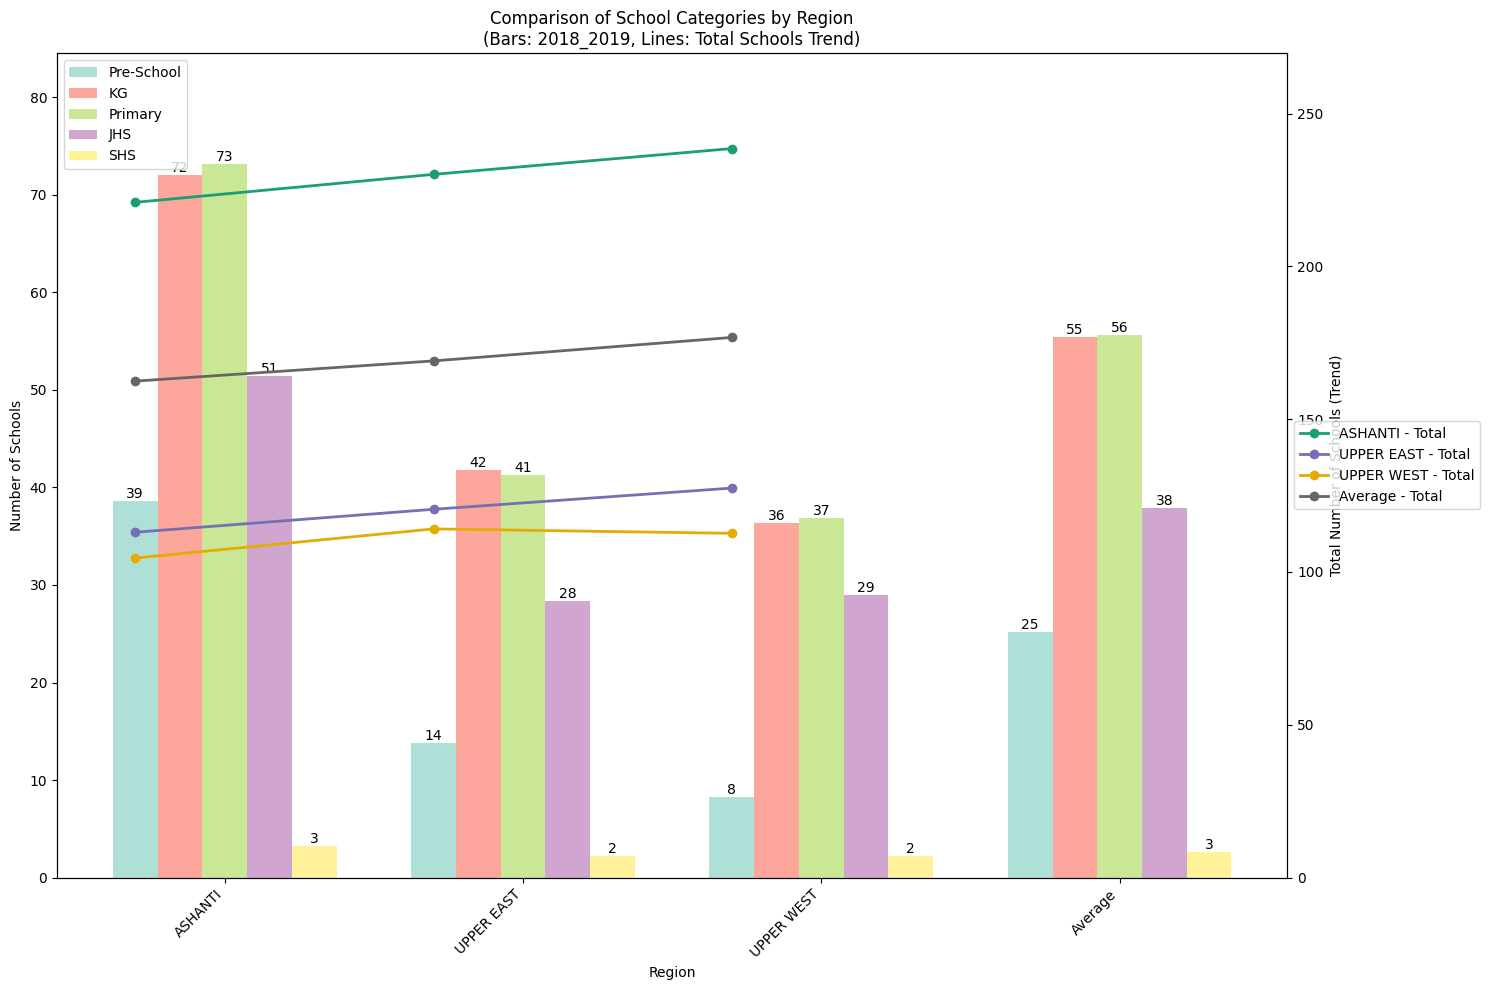

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_simplified_school_comparison(df, regions_to_plot, regions_to_exclude=None):
    if regions_to_exclude is None:
        regions_to_exclude = []
    
    school_type_columns = {
        'Pre-School': 'number_of_pre_school',
        'KG': 'number_of_kg_school',
        'Primary': 'number_of_primary_school',
        'JHS': 'number_of_jhs_school',
        'SHS': 'number_of_shs_school'
    }
    
    # Get available years and sort them
    available_years = sorted(df['Year'].unique())
    most_recent_year = available_years[-1]
    
    print(f"Using data from {available_years[0]} to {most_recent_year}")
    
    # Calculate total number of schools
    df['Total_Schools'] = df[list(school_type_columns.values())].sum(axis=1)
    
    # Prepare data for plotting
    plot_data = {region: df[df['Region'] == region] for region in regions_to_plot}
    
    # Calculate average for other regions
    df_others = df[~df['Region'].isin(regions_to_plot + regions_to_exclude)]
    if not df_others.empty:
        avg_data = df_others.groupby('Year')[['Total_Schools'] + list(school_type_columns.values())].mean().reset_index()
        avg_data['Region'] = 'Average'
        plot_data['Average'] = avg_data
    
    # Plotting
    fig, ax1 = plt.subplots(figsize=(15, 10))
    
    bar_width = 0.15
    index = np.arange(len(plot_data))
    colors = plt.colormaps['Set3'](np.linspace(0, 1, len(school_type_columns)))
    
    # Plot bars for the most recent year
    for i, (school_type, column) in enumerate(school_type_columns.items()):
        values = [data[data['Year'] == most_recent_year][column].values[0] if not data[data['Year'] == most_recent_year].empty else 0 for data in plot_data.values()]
        bars = ax1.bar(index + i * bar_width, values, bar_width, label=school_type, color=colors[i], alpha=0.7)
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.0f}', ha='center', va='bottom')
    
    ax1.set_xlabel('Region')
    ax1.set_ylabel('Number of Schools')
    ax1.set_title(f'Comparison of School Categories by Region\n(Bars: {most_recent_year}, Lines: Total Schools Trend)')
    ax1.set_xticks(index + bar_width * 2)
    ax1.set_xticklabels(plot_data.keys(), rotation=45, ha='right')
    ax1.legend(loc='upper left')
    
    # Plot lines for total schools trend
    ax2 = ax1.twinx()
    line_colors = plt.colormaps['Dark2'](np.linspace(0, 1, len(plot_data)))
    for i, (region, data) in enumerate(plot_data.items()):
        ax2.plot(available_years, data['Total_Schools'], marker='o', linestyle='-', 
                 color=line_colors[i], linewidth=2, label=f'{region} - Total')
    
    ax2.set_ylabel('Total Number of Schools (Trend)')
    
    # Adjust y-axis limits for both axes
    ax1.set_ylim(0, ax1.get_ylim()[1] * 1.1)  # Add 10% padding to the top
    ax2.set_ylim(0, ax2.get_ylim()[1] * 1.1)
    x
    # Add a secondary legend for the trend lines
    lines, labels = ax2.get_legend_handles_labels()
    ax2.legend(lines, labels, loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'combined_data' is your DataFrame

regions_to_plot = ['ASHANTI', 'UPPER EAST', 'UPPER WEST']
regions_to_exclude = ['GREATER ACCRA']

plot_simplified_school_comparison(combined_data, regions_to_plot, regions_to_exclude)

In [35]:
import pandas as pd
import re

def preprocess_teacher_data(df):
    school_levels = ['PreSch', 'Kg', 'Prm', 'JHS', 'SHS']
    
    for level in school_levels:
        # Create patterns to match column names
        pattern1 = f"{level}_Male_|{level}_Female_|{level}_M|{level}_F"
        pattern2 = f"{level}_(M|F)(Trn|UnTrn)"
        
        # Find matching columns
        matching_columns = [col for col in df.columns if re.search(pattern1, col) or re.search(pattern2, col)]
        
        # Sum the matching columns
        if matching_columns:
            df[f'{level}_Teachers'] = df[matching_columns].sum(axis=1)
    
    return df

def group_and_sum_by_region(df, columns_to_sum):
    # Ensure all specified columns exist in the DataFrame
    existing_columns = [col for col in columns_to_sum if col in df.columns and col != 'Year']
    if not existing_columns:
        raise ValueError("None of the specified numeric columns exist in the DataFrame")
    
    # Convert columns to numeric, ignoring errors
    for col in existing_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Group by Region and Year, and calculate the sum of the specified columns
    grouped_df = df.groupby(['Region', 'Year'])[existing_columns].sum().reset_index()
    
    # Sort the DataFrame by Region and Year
    grouped_df = grouped_df.sort_values(['Region', 'Year'])
    
    return grouped_df

def read_multiple_sheets(file_path, sheet_names, columns_to_sum):
    all_data = []
    
    for sheet_name in sheet_names:
        # Read the sheet
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        
        # Preprocess the data to sum up teacher counts
        df = preprocess_teacher_data(df)
        
        # Extract year from sheet name
        year = sheet_name.split('_')[-2] + '_' + sheet_name.split('_')[-1]
        print(f"Processing data for year: {year}")
        
        # Add year column
        df['Year'] = year
        
        # Group and sum the data
        df = group_and_sum_by_region(df, columns_to_sum)
        
        # Append to list
        all_data.append(df)
    
    # Combine all DataFrames
    combined_df = pd.concat(all_data, ignore_index=True)
    
    return combined_df

# Example usage
sheet_names = ['Teachers_2016_2017', 'Teachers_2017_2018', 'Teachers_2018_2019']  # Adjust as needed
columns_to_sum = ['PreSch_Teachers', 'Kg_Teachers', 'Prm_Teachers', 'JHS_Teachers', 'SHS_Teachers']

teachers_data = read_multiple_sheets(path, sheet_names, columns_to_sum)

# Display the first few rows of the combined data
print(combined_data.head())

# Optional: Save the combined data to a CSV file
# combined_data.to_csv('combined_teacher_data.csv', index=False)

Processing data for year: 2016_2017
Processing data for year: 2017_2018
Processing data for year: 2018_2019
          Region       Year  Pop_0_5_Total  Pop_6_11_Total  Pop_12_14_Total  \
0        ASHANTI  2016_2017      1176969.0        987933.0         603533.0   
1    BRONG AHAFO  2016_2017       620344.0        525214.0         313475.0   
2        CENTRAL  2016_2017       547719.0        482399.0         281052.0   
3        EASTERN  2016_2017       670933.0        561087.0         343518.0   
4  GREATER ACCRA  2016_2017       858747.0        672367.0         408278.0   

   Pop_15_17_Total  Total_Population  
0         569966.0         3338401.0  
1         286110.0         1745143.0  
2         263626.0         1574796.0  
3         313959.0         1889497.0  
4         434586.0         2373978.0  


Using data from 2016_2017 to 2018_2019


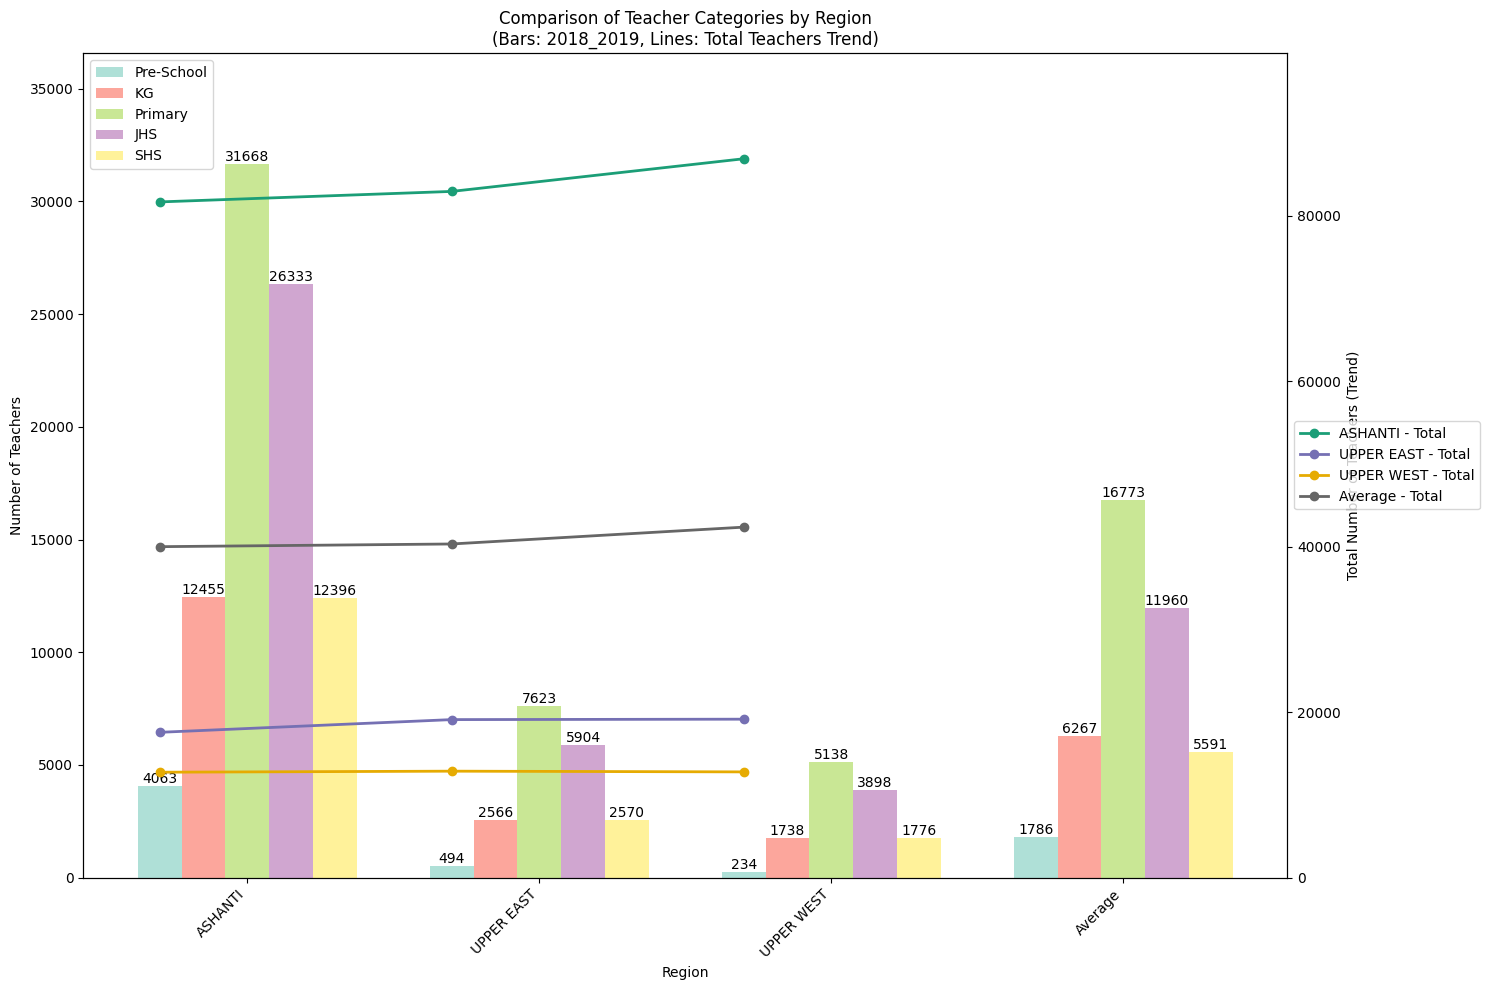

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_simplified_teacher_comparison(df, regions_to_plot, regions_to_exclude=None):
    if regions_to_exclude is None:
        regions_to_exclude = []
    
    teacher_type_columns = {
        'Pre-School': 'PreSch_Teachers',
        'KG': 'Kg_Teachers',
        'Primary': 'Prm_Teachers',
        'JHS': 'JHS_Teachers',
        'SHS': 'SHS_Teachers'
    }
    
    # Get available years and sort them
    available_years = sorted(df['Year'].unique())
    most_recent_year = available_years[-1]
    
    print(f"Using data from {available_years[0]} to {most_recent_year}")
    
    # Calculate total number of teachers
    df['Total_Teachers'] = df[list(teacher_type_columns.values())].sum(axis=1)
    
    # Prepare data for plotting
    plot_data = {region: df[df['Region'] == region] for region in regions_to_plot}
    
    # Calculate average for other regions
    df_others = df[~df['Region'].isin(regions_to_plot + regions_to_exclude)]
    if not df_others.empty:
        avg_data = df_others.groupby('Year')[['Total_Teachers'] + list(teacher_type_columns.values())].mean().reset_index()
        avg_data['Region'] = 'Average'
        plot_data['Average'] = avg_data
    
    # Plotting
    fig, ax1 = plt.subplots(figsize=(15, 10))
    
    bar_width = 0.15
    index = np.arange(len(plot_data))
    colors = plt.colormaps['Set3'](np.linspace(0, 1, len(teacher_type_columns)))
    
    # Plot bars for the most recent year
    for i, (teacher_type, column) in enumerate(teacher_type_columns.items()):
        values = [data[data['Year'] == most_recent_year][column].values[0] if not data[data['Year'] == most_recent_year].empty else 0 for data in plot_data.values()]
        bars = ax1.bar(index + i * bar_width, values, bar_width, label=teacher_type, color=colors[i], alpha=0.7)
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.0f}', ha='center', va='bottom')
    
    ax1.set_xlabel('Region')
    ax1.set_ylabel('Number of Teachers')
    ax1.set_title(f'Comparison of Teacher Categories by Region\n(Bars: {most_recent_year}, Lines: Total Teachers Trend)')
    ax1.set_xticks(index + bar_width * 2)
    ax1.set_xticklabels(plot_data.keys(), rotation=45, ha='right')
    ax1.legend(loc='upper left')
    
    # Plot lines for total teachers trend
    ax2 = ax1.twinx()
    line_colors = plt.colormaps['Dark2'](np.linspace(0, 1, len(plot_data)))
    for i, (region, data) in enumerate(plot_data.items()):
        ax2.plot(available_years, data['Total_Teachers'], marker='o', linestyle='-', 
                 color=line_colors[i], linewidth=2, label=f'{region} - Total')
    
    ax2.set_ylabel('Total Number of Teachers (Trend)')
    
    # Adjust y-axis limits for both axes
    ax1.set_ylim(0, ax1.get_ylim()[1] * 1.1)  # Add 10% padding to the top
    ax2.set_ylim(0, ax2.get_ylim()[1] * 1.1)
    
    # Add a secondary legend for the trend lines
    lines, labels = ax2.get_legend_handles_labels()
    ax2.legend(lines, labels, loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'combined_data' is your DataFrame with teacher data
regions_to_plot = ['ASHANTI', 'UPPER EAST', 'UPPER WEST']
regions_to_exclude = ['GREATER ACCRA']
plot_simplified_teacher_comparison(combined_data, regions_to_plot, regions_to_exclude)

In [36]:
import pandas as pd
import re

def preprocess_population_data(df):
    # Define age groups
    age_groups = {
        'Pop_0_5': ['Pop0_3', 'Pop4', 'Pop4_5', 'Pop5'],
        'Pop_6_11': ['Pop6', 'Pop6_11', 'Pop11'],
        'Pop_12_14': ['Pop12', 'Pop12_14', 'Pop14'],
        'Pop_15_17': ['Pop15', 'Pop15_17', 'Pop17']
    }
    
    # Process each age group
    for group_name, age_ranges in age_groups.items():
        boys_cols = [col for col in df.columns if any(range in col and col.endswith('B') for range in age_ranges)]
        girls_cols = [col for col in df.columns if any(range in col and col.endswith('G') for range in age_ranges)]
        
        df[f'{group_name}_Boys'] = df[boys_cols].sum(axis=1)
        df[f'{group_name}_Girls'] = df[girls_cols].sum(axis=1)
        df[f'{group_name}_Total'] = df[f'{group_name}_Boys'] + df[f'{group_name}_Girls']
    
    # Calculate total population
    total_cols = [col for col in df.columns if col.startswith('Pop') and col.endswith('Total')]
    df['Total_Population'] = df[total_cols].sum(axis=1)
    
    return df

def group_and_sum_by_region(df, columns_to_sum):
    # Ensure all specified columns exist in the DataFrame
    existing_columns = [col for col in columns_to_sum if col in df.columns and col != 'Year']
    if not existing_columns:
        raise ValueError("None of the specified numeric columns exist in the DataFrame")
    
    # Convert columns to numeric, ignoring errors
    for col in existing_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Group by Region and Year, and calculate the sum of the specified columns
    grouped_df = df.groupby(['Region', 'Year'])[existing_columns].sum().reset_index()
    
    # Sort the DataFrame by Region and Year
    grouped_df = grouped_df.sort_values(['Region', 'Year'])
    
    return grouped_df

def read_multiple_sheets(file_path, sheet_names, columns_to_sum):
    all_data = []
    
    for sheet_name in sheet_names:
        # Read the sheet
        df = pd.read_excel(file_path, sheet_name=sheet_name)
        
        # Preprocess the data to group population data
        df = preprocess_population_data(df)
        
        # Extract year from sheet name
        year = sheet_name.split('_')[-2] + '_' + sheet_name.split('_')[-1]
        print(f"Processing data for year: {year}")
        
        # Add year column
        df['Year'] = year
        
        # Group and sum the data
        df = group_and_sum_by_region(df, columns_to_sum)
        
        # Append to list
        all_data.append(df)
    
    # Combine all DataFrames
    combined_df = pd.concat(all_data, ignore_index=True)
    
    return combined_df

# Example usage
sheet_names = ['Population_2016_2017', 'Population_2017_2018', 'Population_2018_2019']  # Adjust as needed
columns_to_sum = ['Pop_0_5_Total', 'Pop_6_11_Total', 'Pop_12_14_Total', 'Pop_15_17_Total', 'Total_Population']

population_data = read_multiple_sheets(path, sheet_names, columns_to_sum)

# Display the first few rows of the combined data
print(combined_data.head())

# Optional: Save the combined data to a CSV file
# combined_data.to_csv('combined_population_data.csv', index=False)

Processing data for year: 2016_2017
Processing data for year: 2017_2018
Processing data for year: 2018_2019
          Region       Year  Pop_0_5_Total  Pop_6_11_Total  Pop_12_14_Total  \
0        ASHANTI  2016_2017      1176969.0        987933.0         603533.0   
1    BRONG AHAFO  2016_2017       620344.0        525214.0         313475.0   
2        CENTRAL  2016_2017       547719.0        482399.0         281052.0   
3        EASTERN  2016_2017       670933.0        561087.0         343518.0   
4  GREATER ACCRA  2016_2017       858747.0        672367.0         408278.0   

   Pop_15_17_Total  Total_Population  
0         569966.0         3338401.0  
1         286110.0         1745143.0  
2         263626.0         1574796.0  
3         313959.0         1889497.0  
4         434586.0         2373978.0  


In [63]:
import pandas as pd

def calculate_education_metrics(schools_data, teachers_data, population_data):
    # Merge the datasets
    merged_data = schools_data.merge(teachers_data, on=['Region', 'Year'])
    merged_data = merged_data.merge(population_data, on=['Region', 'Year'])
    
    # Calculate ratios
#     merged_data['Schools_per_100k'] = (merged_data['number_of_pre_school'] + 
#                                        merged_data['number_of_kg_school'] + 
#                                        merged_data['number_of_primary_school'] + 
#                                        merged_data['number_of_jhs_school'] + 
#                                        merged_data['number_of_shs_school']) / merged_data['Total_Population']

#     merged_data['Teachers_per_100k'] = (merged_data['PreSch_Teachers'] + 
#                                         merged_data['Kg_Teachers'] + 
#                                         merged_data['Prm_Teachers'] + 
#                                         merged_data['JHS_Teachers'] + 
#                                         merged_data['SHS_Teachers']) / merged_data['Total_Population']

    # Calculate students per teacher ratio
    merged_data['Students_per_Teacher'] = (merged_data['Pop_0_5_Total'] + 
                                           merged_data['Pop_6_11_Total'] + 
                                           merged_data['Pop_12_14_Total'] + 
                                           merged_data['Pop_15_17_Total']) / (merged_data['PreSch_Teachers'] + 
                                                                               merged_data['Kg_Teachers'] + 
                                                                               merged_data['Prm_Teachers'] + 
                                                                               merged_data['JHS_Teachers'] + 
                                                                               merged_data['SHS_Teachers'])

    # Select relevant columns
    result = merged_data[['Region', 'Year', 'Students_per_Teacher']]
    
    return result

education_metrics = calculate_education_metrics(schools_data, teachers_data, population_data)
print(education_metrics.head())

filtered_df = education_metrics[education_metrics['Region'] == 'UPPER WEST']
filtered_df

        Region       Year  Students_per_Teacher
0      ASHANTI  2016_2017             40.862702
1      ASHANTI  2017_2018              0.000000
2      ASHANTI  2018_2019              0.000000
3  BRONG AHAFO  2016_2017             39.610128
4  BRONG AHAFO  2017_2018              0.000000


,Region,Year,Students_per_Teacher
20,UPPER WEST,2016_2017,42.180841
21,UPPER WEST,2017_2018,0.000000
22,UPPER WEST,2018_2019,0.000000


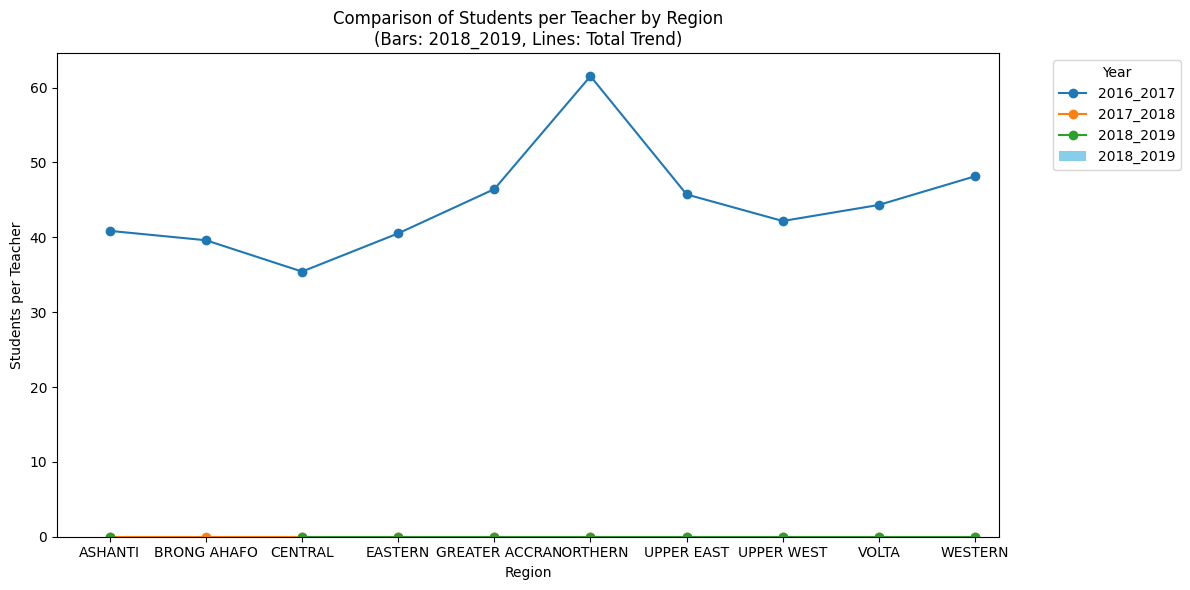

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your dataset is stored in a variable called 'education_metrics'
# If it's in a CSV file, you can load it using:
# education_metrics = pd.read_csv('your_file_name.csv')

# Filter data for the years 2016_2017 to 2018_2019
years_to_use = ['2016_2017', '2017_2018', '2018_2019']
filtered_data = education_metrics[education_metrics['Year'].isin(years_to_use)]

# Pivot the data to get it in the right format for plotting
pivoted_data = filtered_data.pivot(index='Region', columns='Year', values='Students_per_Teacher')

# Create the plot
plt.figure(figsize=(12, 6))

# Plot the bars for 2018_2019
ax = pivoted_data['2018_2019'].plot(kind='bar', position=1, width=0.3, color='skyblue', label='2018_2019')

# Plot lines for the trend
pivoted_data.plot(kind='line', ax=ax, marker='o')

# Customize the plot
plt.title('Comparison of Students per Teacher by Region\n(Bars: 2018_2019, Lines: Total Trend)')
plt.xlabel('Region')
plt.ylabel('Students per Teacher')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()